# Applied Pharmaceutical Bioinformatics - Exam instructions

# Objective
You are given a dataset of small molecules and their biological activity (𝐾𝑖, in 𝑛𝑀). Your task
is to explore the data, build regression and classification models, evaluate them, and reflect
on your modelling process and results.

# Instructions

Submit a PDF report. Code is optional but encouraged as an appendix or separate file.

1. Data Exploration
    - Load and inspect the dataset.
    - Analyse the distribution of 𝐾𝑖 and decide whether to apply a log-transformation (e.g., log10(𝐾𝑖)). Justify your choice and apply it if appropriate.
2. Descriptor Preparation
    - Generate suitable molecular descriptors (e.g., ECFP4, RDKit descriptors).
    - Justify your descriptor choices.
3. Descriptor Space Visualization
    - Use at least one dimensionality reduction method (e.g., PCA, t-SNE, UMAP).
    - Highlight clustering or separation of actives/inactives.
    - Comment on how structurally diverse the dataset appears based on clustering or spread in the projected space.
    - Optionally compare multiple methods.
4. Modelling
    - Use and compare at least three machine learning methods for each task.
    1. Regression
        - Build and evaluate regression models using 10-fold cross-validation.
        - Report 𝑅2 and 𝑀𝑆𝐸.
    2. Classification
        - Choose at least two thresholds for active/inactive classification. Try to make one chemically meaningful value (e.g., 𝐾𝑖 < 1000 nM) and one which gives a more unrealistic but balanced setup.
        - For each threshold:
            1. Train three models using descriptors.
            2. Evaluate with 10-fold cross-validation (CV).
            3. Report AUC, precision, recall, F1-score.
            4. Reflect on how thresholds affect class balance, interpretability and usefulness.
5. Discussion
    - Compare model performance and metric outcomes.
    - Discuss effects of descriptor relevance, threshold impact, and class imbalance.
6. Report Format
    - Recommended structure:
        1. Introduction
        2. Methods
        3. Results
        4. Discussion
        5. Conclusion
    - Suggested length: 4–6 pages.
7. Submission
    - Submit your PDF report.
    - Code is optional but encouraged.

---

# Code

In [1785]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Exploration

In [1786]:
# load in and inspect the dataset
df = pd.read_csv("exam_dataset.csv")
print(df.head())

                                              SMILES  Ki (nM)
0        Cc1cc(C)cc(NC(=O)NCc2ccc(Cc3c[nH]cn3)cc2)c1      9.0
1  O=C(NCc1ccc(Cc2c[nH]cn2)cc1)NCc1cc(C(F)(F)F)cc...     90.0
2     O=C(CCCOCCCc1c[nH]cn1)c1ccc(F)cc1.O=C(O)C(=O)O     14.0
3         O=C(O)/C=C\C(=O)O.c1nc(COCCC2CCCCC2)c[nH]1    500.0
4      O=C(Nc1cc(Cl)cc(Cl)c1)OCc1ccc(Cc2c[nH]cn2)cc1      5.0


In [1787]:
# get an overview of each column and data type
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7562 entries, 0 to 7561
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SMILES   7562 non-null   object 
 1   Ki (nM)  7556 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.3+ KB
None


In [1788]:
print("Num unique: %s out of %s records in total" % (df['SMILES'].nunique(), len(df['SMILES'])))
print("Percentage of unique records: " + str((df['SMILES'].nunique()/len(df['SMILES']))*100) + "%")

Num unique: 4893 out of 7562 records in total
Percentage of unique records: 64.705104469717%


In [1789]:
# generate some summary statistics: count, mean, std, min, max, IQR
print(df.describe(include='all'))

                                    SMILES       Ki (nM)
count                                 7562  7.556000e+03
unique                                4893           NaN
top     S=C(NC1CCCCC1)N1CCC(c2cnc[nH]2)CC1           NaN
freq                                    62           NaN
mean                                   NaN  7.656691e+14
std                                    NaN  2.938241e+16
min                                    NaN  2.000000e-02
25%                                    NaN  2.900000e+00
50%                                    NaN  1.500000e+01
75%                                    NaN  9.300000e+01
max                                    NaN  1.995262e+18


In [1790]:
# inspect any missing data
df[df.isnull().any(axis=1)]

SMILES  Ki (nM)
20             CCCCCCCCOCCCc1c[nH]cn1.O=C(O)/C=C\C(=O)O      NaN
21    O/N=C(/CCCOCCCc1c[nH]cn1)c1ccc(F)cc1.O=C(O)/C=...      NaN
1295                          S=C(NCCCn1ccnc1)NC1CCCCC1      NaN
1609                  ClCC/C=C/c1ccc(OCCCc2c[nH]cn2)cc1      NaN
1611                   c1nc(CCCOc2ccc(CC3CC3)cc2)c[nH]1      NaN
1620            O=C(CCCN1CCCC1)c1ccc(OCCCc2c[nH]cn2)cc1      NaN

In [1791]:
# test for normality using kurtosis
# print(df.kurt())

In [1792]:
# mean, median, mode
# print(df.mean())
# print(df.median())
# print(df.mode())

In [1793]:
# boxplot for Y-variable
# sns.boxplot(x="Ki (nM)", data=df)
# plt.show()
# plt.close()

In [1794]:
# histogram for Y-variable
# sns.histplot(x="Ki (nM)", data=df)
# plt.show()
# plt.close()

### Optional: Deal with Missing Data

In [1795]:
# drop rows where the Ki is missing
df = df[df['Ki (nM)'].notna()]

In [1796]:
# drop duplicate SMILES values
df = df.drop_duplicates(subset=['SMILES'])

## Descriptor Preparation

In [1797]:
import statsmodels.api as sm
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen

In [1798]:
# Configure the logging - RDKit is rather verbose..
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

### RDKit Descriptors

In [1799]:
target_column = "Ki (nM)" # inhibitory constant
smiles_column = "SMILES"

In [1800]:
# define list of descriptors to calculate
descriptor_names = ['MolWt', 'MolLogP', 'TPSA', 'FractionCSP3', 'BalabanJ']

In [1801]:
# compute descriptors for a molecule
def compute_descriptors(smiles):
    """
    Takes a SMILES string as input and computes a range of descriptors from RDKit package.

    Output columns: Mol Wgt, Partial Coefficient LogP, Total Polar Surface Area (TPSA), MolMR, Heavy Atom Count, No. Hetero Atoms, No. Rotatable Bonds, No. Rings, No. Aliphatic Rings, No. Aromatic Rings, No. Valence Electrons, No. H-Donors and Acceptors, CSP3 Fraction, BalabanJ
    """
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        descriptors = []
        
        for name in descriptor_names:
            descriptor = getattr(Descriptors, name)
            descriptors.append(descriptor(mol))
        
        return descriptors
    else:
        # return None for molecules that cannot be parsed
        return [None]*len(descriptor_names)

In [1802]:
# compute descriptors for all molecules
descriptor_list = []

for index, row in df.iterrows():
    smiles = row[smiles_column]
    descriptors = compute_descriptors(smiles)
    descriptor_list.append(descriptors)

In [1803]:
# Create a DataFrame with descriptors
descriptor_df = pd.DataFrame(descriptor_list, columns=descriptor_names)

# Combine descriptors with the target variable
result_df = pd.concat([df["Ki (nM)"], descriptor_df], axis=1)

# Remove rows with None values (failed descriptor calculations)
result_df = result_df.dropna()

# Save the new dataset to a CSV file
output_filename = 'exam_output.csv'
result_df.to_csv(output_filename, index=False)

print(f"\nDescriptor dataset saved to '{output_filename}'.")


Descriptor dataset saved to 'exam_output.csv'.


## Descriptor Space Visualization

In [1804]:
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform

In [1805]:
# Load the CSV file
data = pd.read_csv('exam_output.csv')

In [1806]:
print("First 5 rows of new dataset:")
print(data.head())

First 5 rows of new dataset:
   Ki (nM)    MolWt  MolLogP    TPSA  FractionCSP3      BalabanJ
0      9.0  334.423  3.93904   69.81      0.200000  1.512164e+00
1     90.0  456.390  5.03750   69.81      0.238095  1.552294e+00
2     14.0  380.372  2.31670  129.58      0.333333  5.271428e-07
3    500.0  324.377  2.60850  112.51      0.562500  2.836666e-07
4      5.0  376.243  5.05600   67.01      0.111111  1.512164e+00


### Min Max Scaling

In [1807]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [1808]:
min_max_scaler = MinMaxScaler(feature_range = (0,1))
data = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data.columns)

print(data.head())

        Ki (nM)     MolWt   MolLogP      TPSA  FractionCSP3      BalabanJ
0  1.129099e-16  0.188978  0.423661  0.218384      0.200000  4.949653e-01
1  1.132639e-15  0.292210  0.516344  0.218384      0.238095  5.081008e-01
2  1.758561e-16  0.227869  0.286775  0.414461      0.333333  1.725457e-07
3  6.294234e-15  0.180476  0.311396  0.358462      0.562500  9.285051e-08
4  6.255286e-17  0.224375  0.517904  0.209199      0.111111  4.949653e-01


### Dealing with outliers

In [1809]:
print(data.shape)

(3181, 6)


In [1810]:
print(data.head(10))

        Ki (nM)     MolWt   MolLogP      TPSA  FractionCSP3      BalabanJ
0  1.129099e-16  0.188978  0.423661  0.218384      0.200000  4.949653e-01
1  1.132639e-15  0.292210  0.516344  0.218384      0.238095  5.081008e-01
2  1.758561e-16  0.227869  0.286775  0.414461      0.333333  1.725457e-07
3  6.294234e-15  0.180476  0.311396  0.358462      0.562500  9.285051e-08
4  6.255286e-17  0.224375  0.517904  0.209199      0.111111  4.949653e-01
5  4.657631e-15  0.247286  0.512800  0.160713      0.200000  5.338341e-01
6  4.024627e-16  0.194388  0.426745  0.218384      0.111111  4.938567e-01
7  2.262132e-16  0.190648  0.372340  0.248663      0.157895  4.892856e-01
8  3.395164e-16  0.146565  0.216237  0.358462      0.461538  1.673242e-07
9  7.301374e-15  0.112654  0.136393  0.358462      0.500000  1.198199e-07


<Axes: >

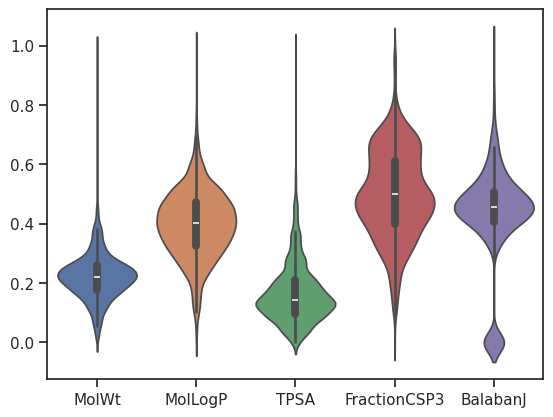

In [1811]:
# violin plots for predictor variables
sns.violinplot(data=data.iloc[:, 1:])

In [1812]:
data["z_molwt"] = np.abs(stats.zscore(data["MolWt"]))
data["z_molLogP"] = np.abs(stats.zscore(data["MolLogP"]))
data["z_TPSA"] = np.abs(stats.zscore(data["TPSA"]))
data["z_csp3"] = np.abs(stats.zscore(data["FractionCSP3"]))
data["z_balabanJ"] = np.abs(stats.zscore(data["BalabanJ"]))

In [1813]:
# drop rows where z-score columns > 2
data = data[data["z_molwt"] < 2]
data = data[data["z_molLogP"] < 2]
data = data[data["z_TPSA"] < 2]
data = data[data["z_csp3"] < 2]
data = data[data["z_balabanJ"] < 2]

In [1814]:
# drop z-score columns
data = data.drop(["z_molwt", "z_molLogP", "z_TPSA", "z_csp3", "z_balabanJ"], axis=1)

<Axes: >

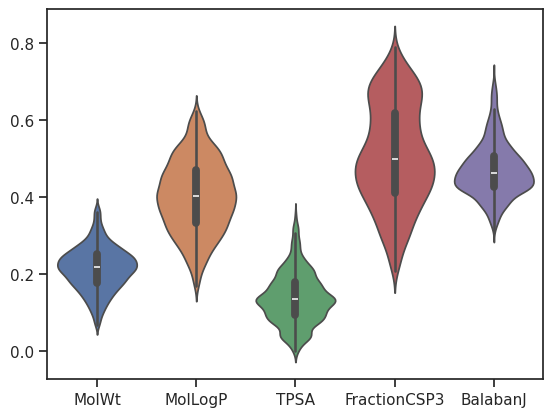

In [1815]:
# violin plots for predictor variables
sns.violinplot(data=data.iloc[:, 1:])

In [1816]:
print(data.shape)

(2461, 6)


### Clustering

#### Agglomerative clustering

In [1817]:
# Set a random seed for reproducibility
random_seed = 42 # the answer to life, the universe, and everything

# Sample 200 rows from the data
sampled_data = data.sample(n=200, random_state=random_seed)

In [1818]:
# Extract relevant columns
# features = sampled_data[['MolecularWeight', 'TPSA', 'ALogP']].dropna()

# Normalise the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sampled_data)

In [1819]:
# Perform Agglomerative Clustering
n_clusters = 3  # Choose the number of clusters
model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
model.fit(scaled_features)

# Add cluster labels to the sampled data
sampled_data['Cluster'] = model.labels_

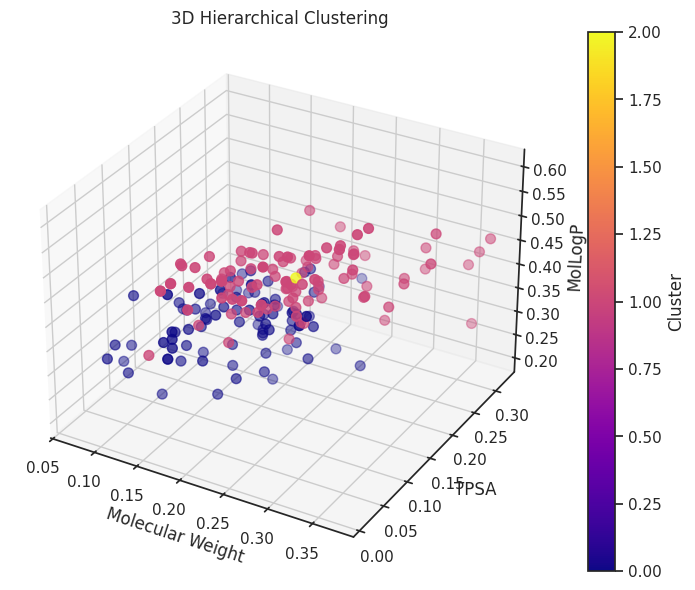

In [1820]:
# Plot the results in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(sampled_data['MolWt'], sampled_data['TPSA'], sampled_data['MolLogP'], c=model.labels_, cmap='plasma', s=50)
ax.set_title('3D Hierarchical Clustering')
ax.set_xlabel('Molecular Weight')
ax.set_ylabel('TPSA')
ax.set_zlabel('MolLogP')
plt.colorbar(sc, ax=ax, label='Cluster')
plt.savefig('3d_clustering.png', format='png')  # Save the 3D plot as a PNG file
plt.show()

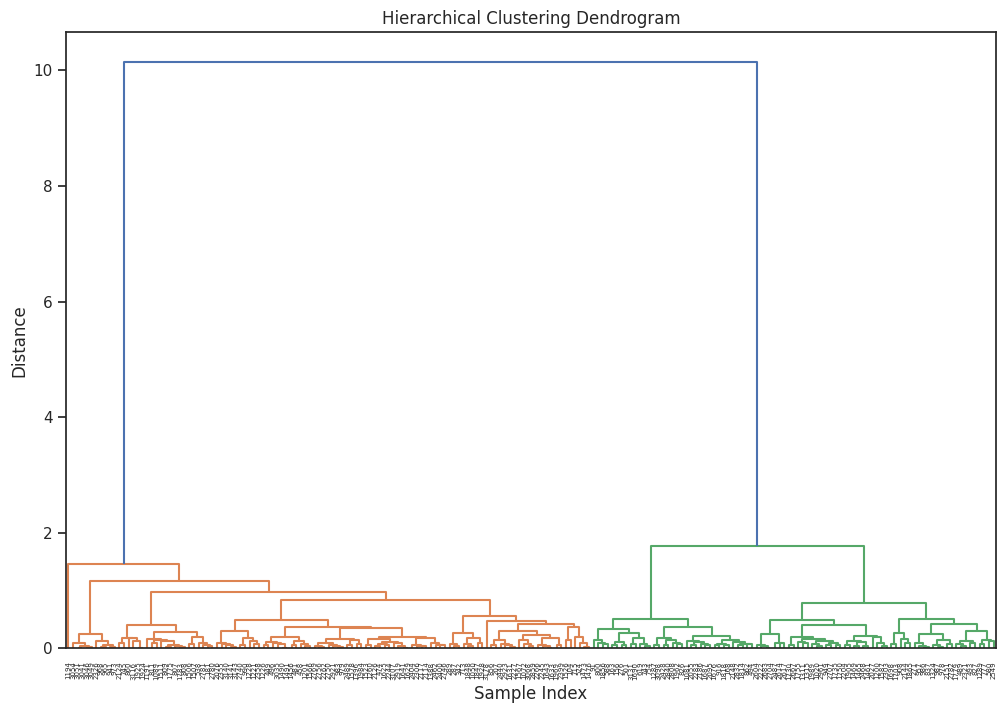

In [1821]:
# Dendrogram using scipy for visualization
Z = linkage(sampled_data, method='ward')
plt.figure(figsize=(12, 8))

dendrogram(Z, labels=sampled_data.index)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.savefig('dendrogram.png', format='png')  # Save the dendrogram as a PNG file
plt.show()

#### Multi-dimensional scaling to visualise clustering

In [1822]:
# Compute the distance matrix
distance_matrix = squareform(pdist(scaled_features, metric='euclidean')) # experiment with Manhattan distance

In [1823]:
# Perform Classical MDS for dimensionality reduction
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_seed)
mds_features = mds.fit_transform(distance_matrix)

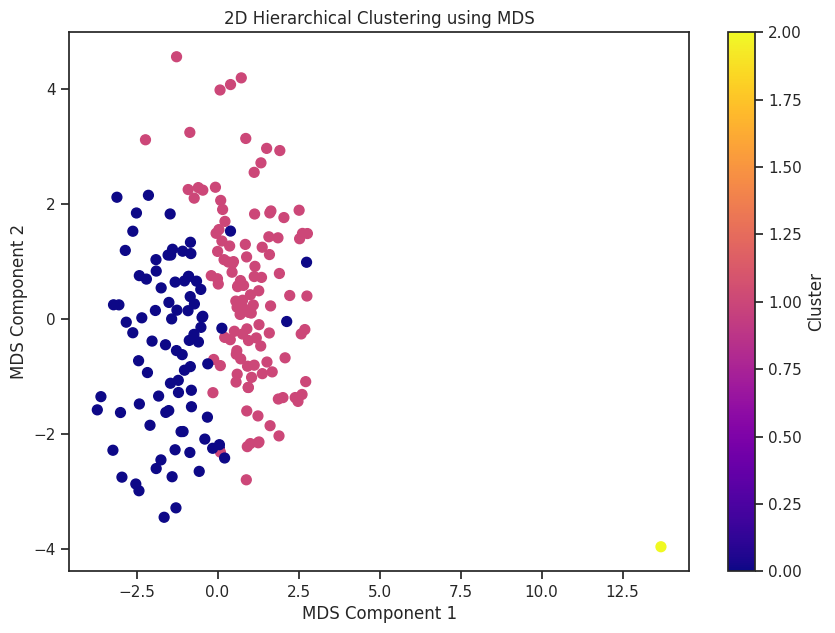

In [1824]:
# Plot the results in 2D using MDS components
plt.figure(figsize=(10, 7))
sc = plt.scatter(mds_features[:, 0], mds_features[:, 1], c=sampled_data['Cluster'], cmap='plasma', s=50)
plt.title('2D Hierarchical Clustering using MDS')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.colorbar(sc, label='Cluster')
plt.savefig('2d_clustering_mds.png', format='png')  # Save the 2D plot as a PNG file
plt.show()

#### *k*-means clustering

In [1825]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [1826]:
# Perform K-Means Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed)
sampled_data['k-Cluster'] = kmeans.fit_predict(scaled_features)

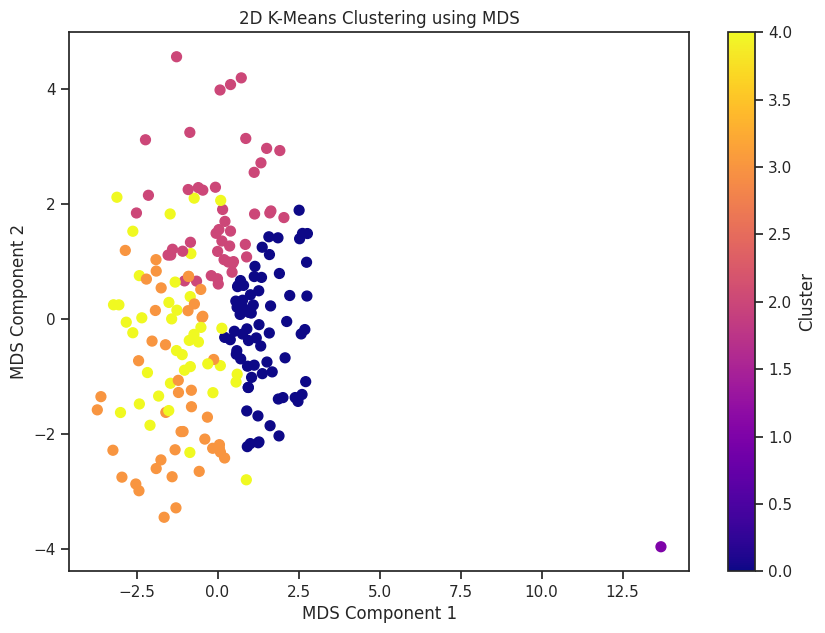

In [1827]:
# Plot the K-Means clustering result using MDS
distance_matrix = squareform(pdist(scaled_features, metric='euclidean'))
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_seed)
mds_features = mds.fit_transform(distance_matrix)

plt.figure(figsize=(10, 7))
sc = plt.scatter(mds_features[:, 0], mds_features[:, 1], c=sampled_data['k-Cluster'], cmap='plasma', s=50)
plt.title('2D K-Means Clustering using MDS')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.colorbar(sc, label='Cluster')
plt.savefig('2d_clustering_mds_kmeans.png', format='png')  # Save the 2D plot as a PNG file
plt.show()

In [1828]:
# Calculate the sum of squares for each cluster
cluster_sums_of_squares = []

for i in range(n_clusters):
    # Get points belonging to the cluster
    mask = sampled_data['k-Cluster'] == i
    cluster_points = scaled_features[mask.values]

    # Calculate the sum of squares for this cluster
    center = kmeans.cluster_centers_[i]
    sum_of_squares = np.sum((cluster_points - center) ** 2)
    cluster_sums_of_squares.append(sum_of_squares)

# Print the sum of squares for each cluster
for i, sum_of_squares in enumerate(cluster_sums_of_squares):
    print(f"Cluster {i}: Sum of Squares = {sum_of_squares:.2f}")

Cluster 0: Sum of Squares = 158.83
Cluster 1: Sum of Squares = 0.00
Cluster 2: Sum of Squares = 146.10
Cluster 3: Sum of Squares = 136.39
Cluster 4: Sum of Squares = 90.02


In [1829]:
# Calculate Total Variance (TSS)
overall_mean = np.mean(scaled_features, axis=0)
tss = np.sum((scaled_features - overall_mean) ** 2)

# Calculate the percentage of variance explained by clustering
variance_explained = 1 - (kmeans.inertia_ / tss)

# Print the percentage of variance explained
print(f"Percentage of Variance Explained by Clustering: {variance_explained * 100:.2f}%")

Percentage of Variance Explained by Clustering: 55.72%


#### Elbow plot

In [1830]:
import warnings
warnings.filterwarnings('ignore')

In [1831]:
# Range of cluster numbers to try
cluster_range = range(1, 31)

In [1832]:
# List to store inertia values
inertia_values = []

# Calculate inertia for each number of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed)
    kmeans.fit(scaled_features)
    inertia_values.append(kmeans.inertia_)

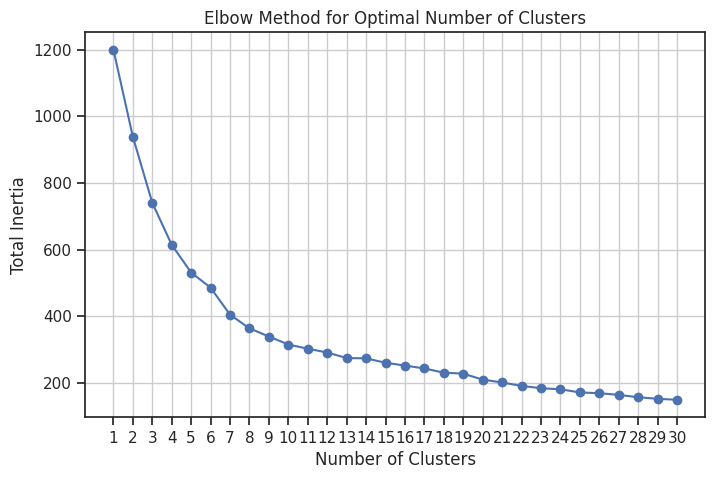

In [1833]:
# Plot the inertia values to find the "elbow"
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Total Inertia')
plt.xticks(cluster_range)
plt.grid(True)

# Save the plot to a file
plt.savefig('elbow_method_plot.png', format='png')

# Display the plot
plt.show()

### Outlier Detection

In [1834]:
data.columns

Index(['Ki (nM)', 'MolWt', 'MolLogP', 'TPSA', 'FractionCSP3', 'BalabanJ'], dtype='object')

In [1835]:
# Select 200 random samples
random_seed = 42
sampled_data = data.sample(n=200, random_state=random_seed)

# Features to plot
features = ['TPSA', 'MolWt', 'MolLogP', 'FractionCSP3', 'BalabanJ']

In [1836]:
# Define properties for outliers
flierprops = dict(marker='o', markerfacecolor='red', markersize=8, linestyle='none')

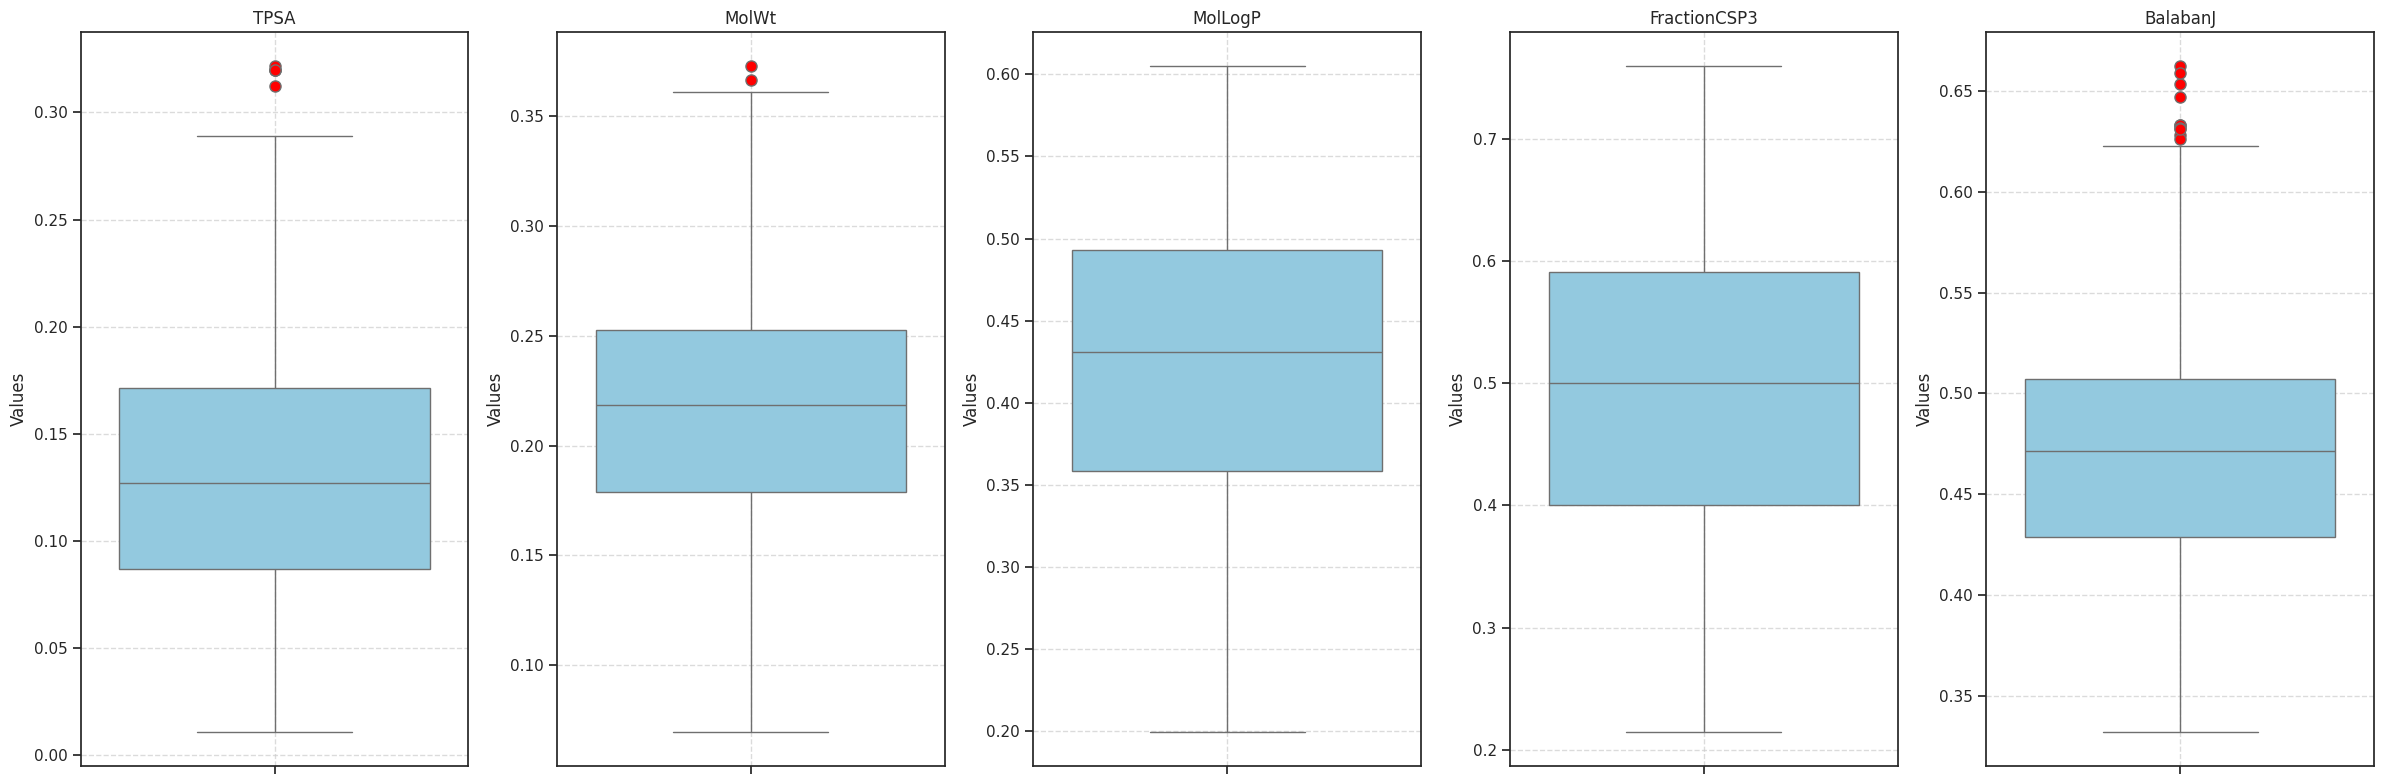

In [1837]:
# Create a boxplot for each feature
plt.figure(figsize=(24, 8)) 
for i, feature in enumerate(features, 1):
    plt.subplot(1, 5, i)  # Arrange plots in a single row
    sns.boxplot(y=sampled_data[feature], color='skyblue', flierprops=flierprops)
    plt.title(f'{feature}')
    plt.ylabel('Values')
    plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('boxplots.png', format='png')

# Show the plot
plt.show()

#### MDS plot for outlier detection

In [1838]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

In [1839]:
# use same random seed and sampled data as above
# Select 200 random samples
# random_seed = 42
# sampled_data = data.sample(n=200, random_state=random_seed)

# Identify outliers for each feature
outlier_indices = set()

for feature in features:
    # Calculate Q1, Q3, and IQR for the sampled data
    Q1 = sampled_data[feature].quantile(0.25)
    Q3 = sampled_data[feature].quantile(0.75)
    IQR = Q3 - Q1
    # Determine outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outlier indices within the sampled data
    feature_outliers = sampled_data[(sampled_data[feature] < lower_bound) | (sampled_data[feature] > upper_bound)].index
    outlier_indices.update(feature_outliers)

In [1840]:
# Convert the outlier indices to a list of their corresponding positions in the sampled_data DataFrame
outlier_positions = sampled_data.index.get_indexer_for(list(outlier_indices))

# Standardise the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sampled_data[features])

# Perform MDS on the full data
distance_matrix = squareform(pdist(scaled_features, metric='euclidean'))
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_seed)
mds_features = mds.fit_transform(distance_matrix)

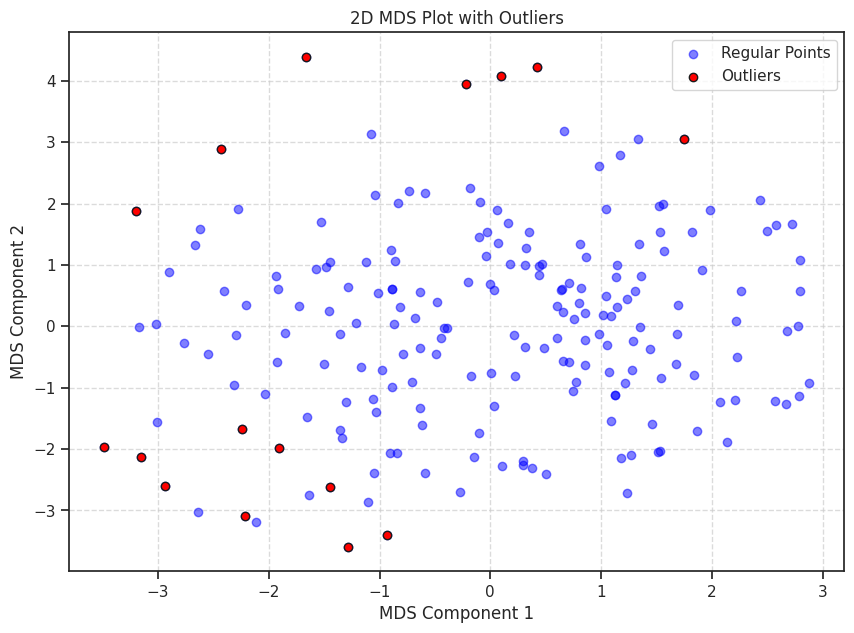

In [1841]:
# Plot the MDS result
plt.figure(figsize=(10, 7))
plt.scatter(mds_features[:, 0], mds_features[:, 1], c='blue', label='Regular Points', alpha=0.5)

# Highlight outliers using the outlier positions
mds_outliers = mds_features[outlier_positions]
plt.scatter(mds_outliers[:, 0], mds_outliers[:, 1], c='red', label='Outliers', edgecolor='k')

plt.title('2D MDS Plot with Outliers')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Save the plot to a file
plt.savefig('mds_outliers_plot.png', format='png')

# Show the plot
plt.show()

### Dimensionality reduction

In [1842]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [1843]:
# use the df stored in "data" variable, which has the pre-rendered descriptors in situ

# Display the first few rows of the DataFrame
print(data.head()) 

         Ki (nM)     MolWt   MolLogP      TPSA  FractionCSP3  BalabanJ
1   1.132639e-15  0.292210  0.516344  0.218384      0.238095  0.508101
22  1.380884e-16  0.134732  0.345610  0.169734      0.375000  0.472105
39  2.639809e-16  0.153454  0.327241  0.133550      0.733333  0.478026
40  3.398705e-15  0.242996  0.387713  0.169734      0.375000  0.503566
41  2.010347e-16  0.220088  0.360933  0.209199      0.230769  0.552440


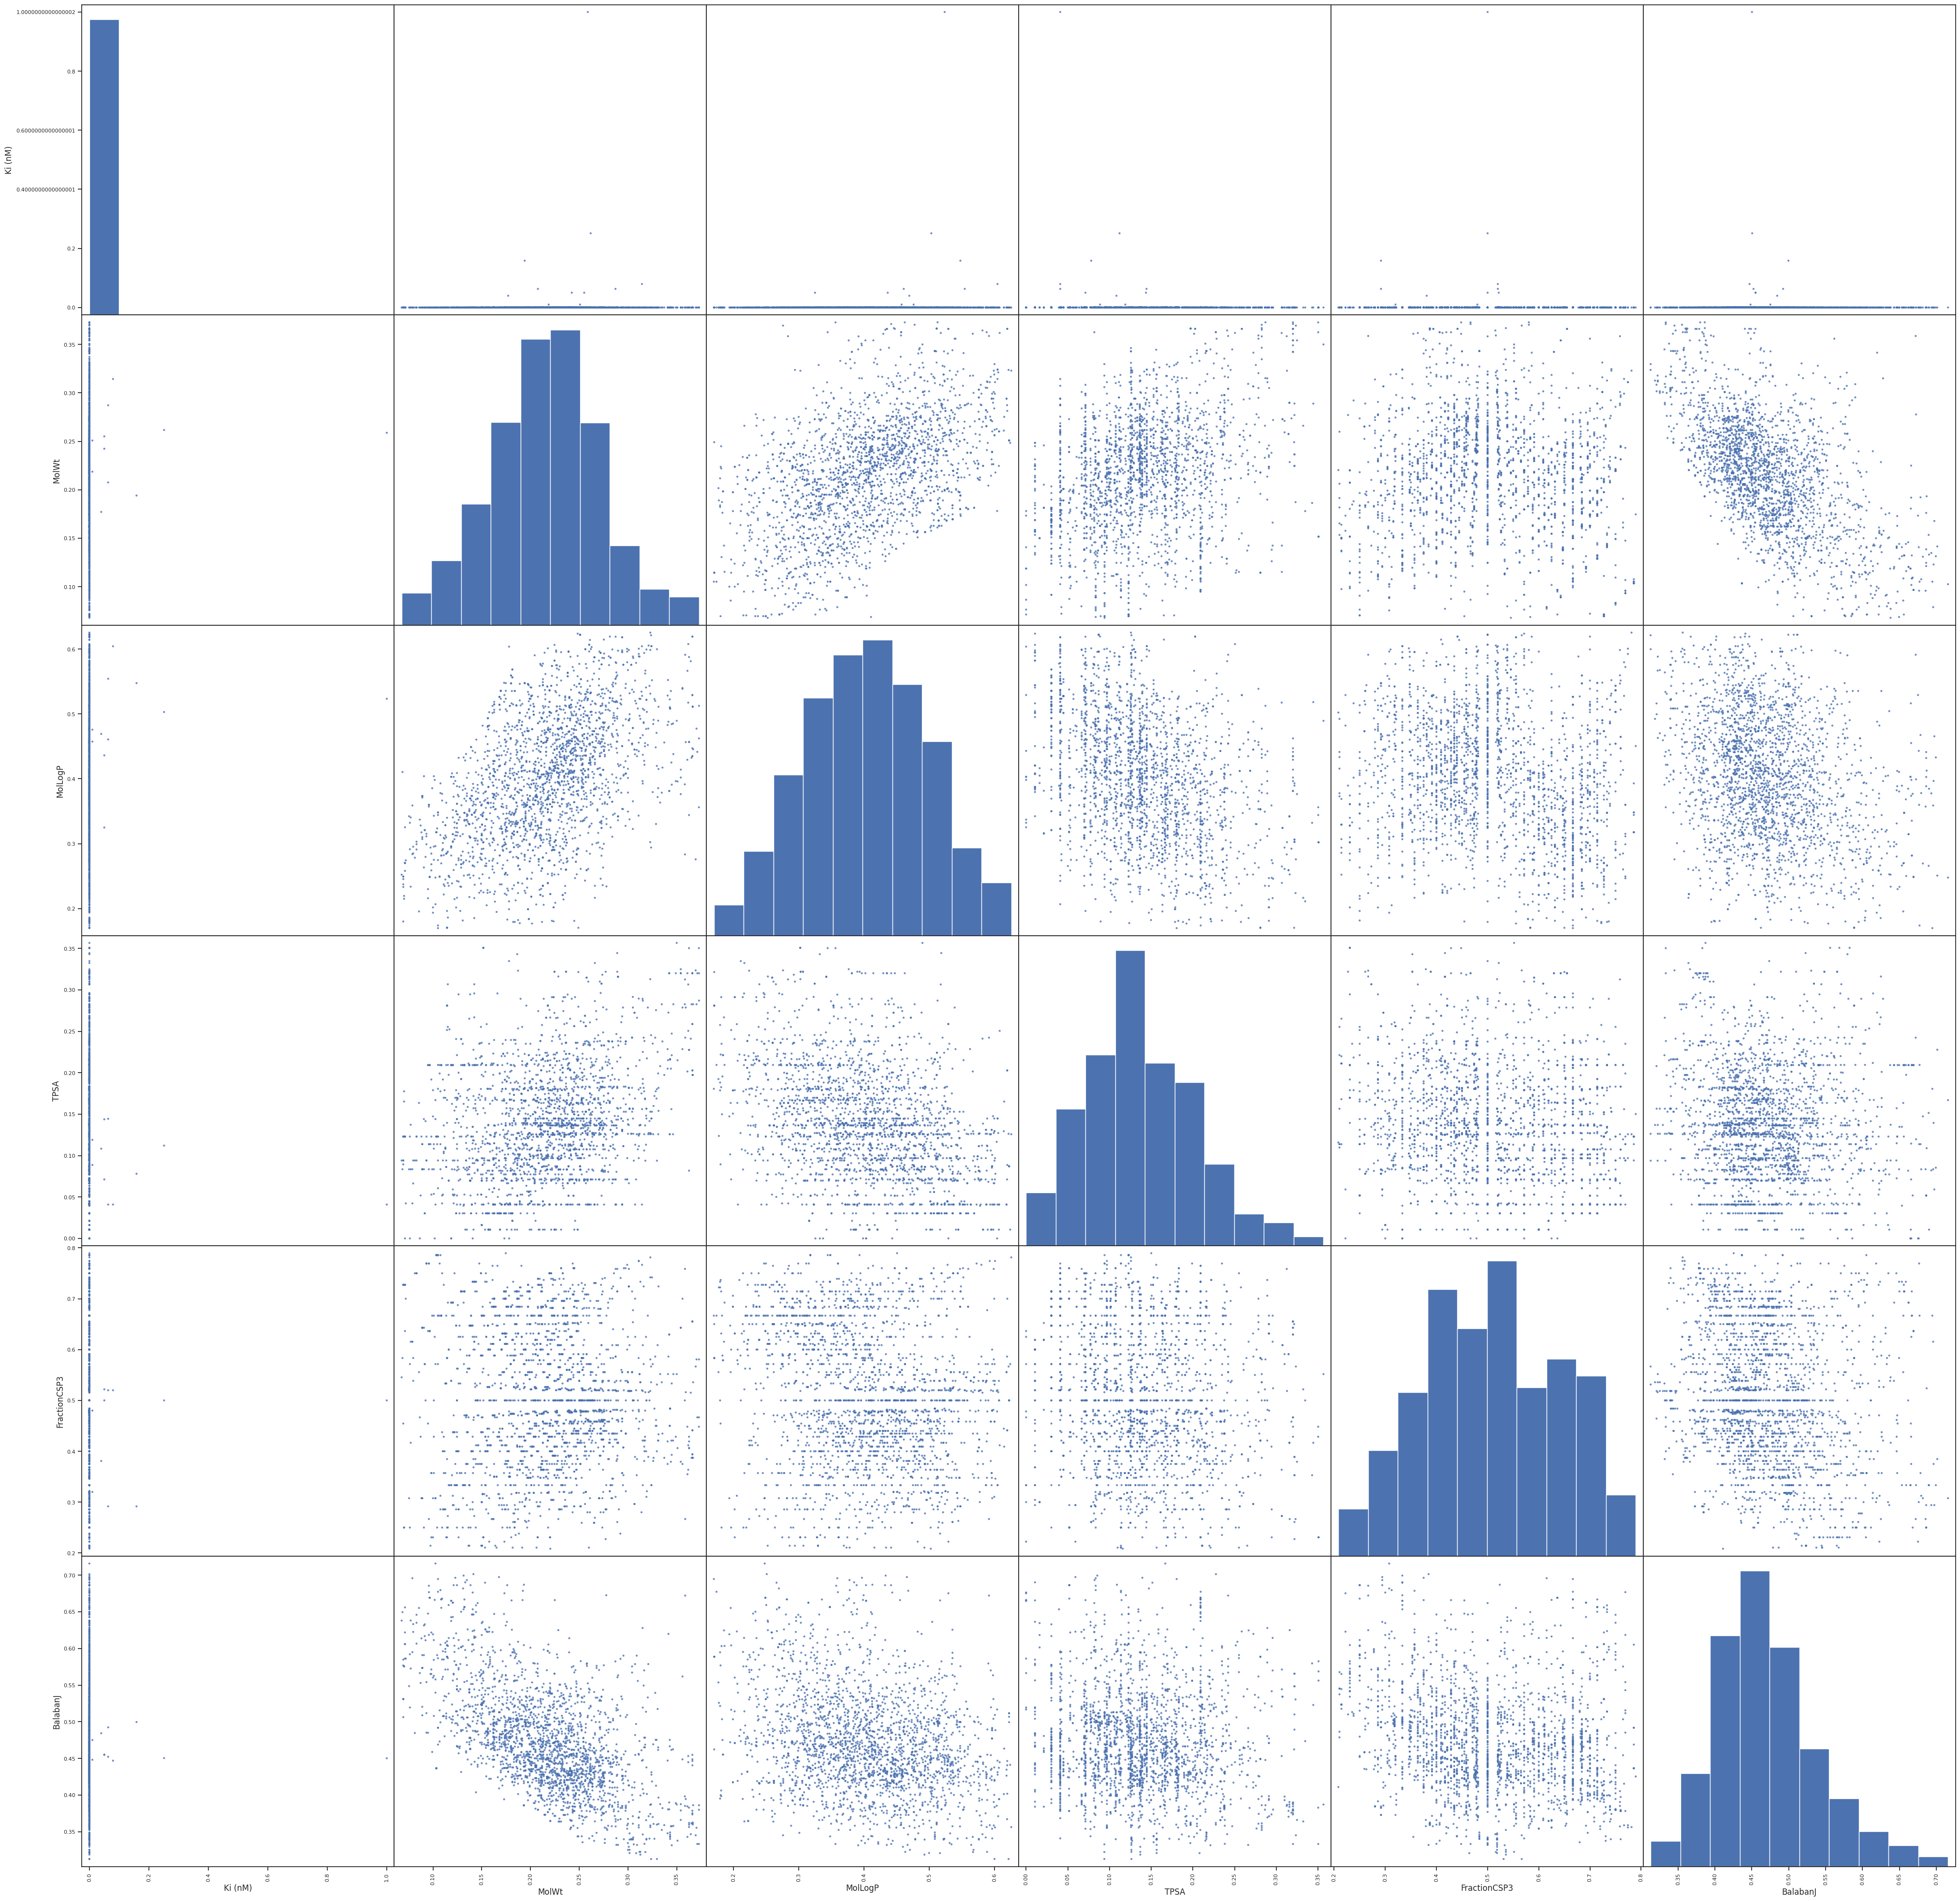

In [1844]:
# Create a scatter matrix plot
scatter_matrix(data, alpha=0.8, figsize=(50, 50), diagonal='hist')

# Save the plot to a file
plt.savefig('scatter_matrix.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [1845]:
# Calculate the correlation matrix
correlation_matrix = data.corr().round(2)

# Display the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
              Ki (nM)  MolWt  MolLogP  TPSA  FractionCSP3  BalabanJ
Ki (nM)          1.00   0.02     0.04 -0.04         -0.01     -0.01
MolWt            0.02   1.00     0.49  0.31         -0.04     -0.59
MolLogP          0.04   0.49     1.00 -0.37         -0.19     -0.28
TPSA            -0.04   0.31    -0.37  1.00         -0.14     -0.09
FractionCSP3    -0.01  -0.04    -0.19 -0.14          1.00     -0.20
BalabanJ        -0.01  -0.59    -0.28 -0.09         -0.20      1.00


#### Principal Component Analysis

In [1846]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [1847]:
# Standardise the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [1848]:
# Perform PCA
pca = PCA(n_components=4)  # Adjust the number of components as needed
pca_results = pca.fit_transform(scaled_data)

In [1849]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

print("\nExplained Variance Ratio:")
print(explained_variance)


Explained Variance Ratio:
[0.32050754 0.2224925  0.19382032 0.16525407]


In [1850]:
# Create a DataFrame for the principal components
pca_df = pd.DataFrame(data=pca_results, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
print("\nPrincipal Components DataFrame:")
print(pca_df.head())


Principal Components DataFrame:
        PC1       PC2       PC3       PC4
0  1.307860  0.500992 -2.593886 -0.144008
1 -1.174048  0.422974 -0.754564  0.019240
2 -1.205276  0.175199  1.738494  0.122158
3  0.030029  0.488306 -1.141840 -0.019354
4 -0.705137  0.932554 -2.376475  0.007309


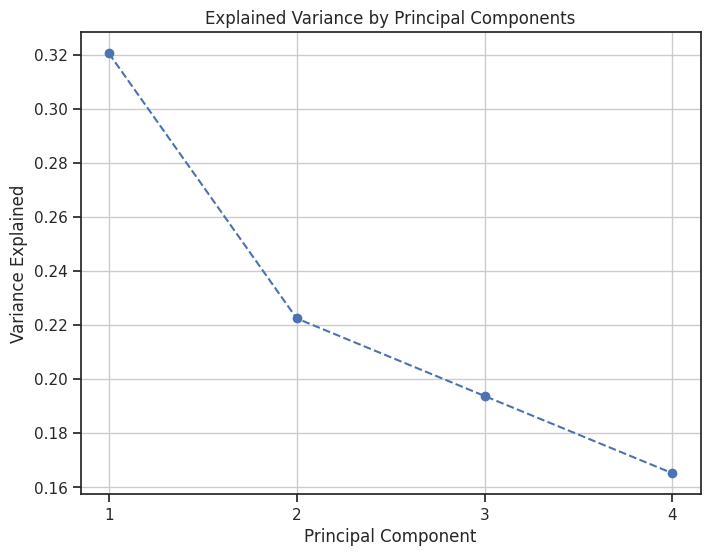

In [1851]:
# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)

# Save the explained variance plot to a file
plt.savefig('explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()

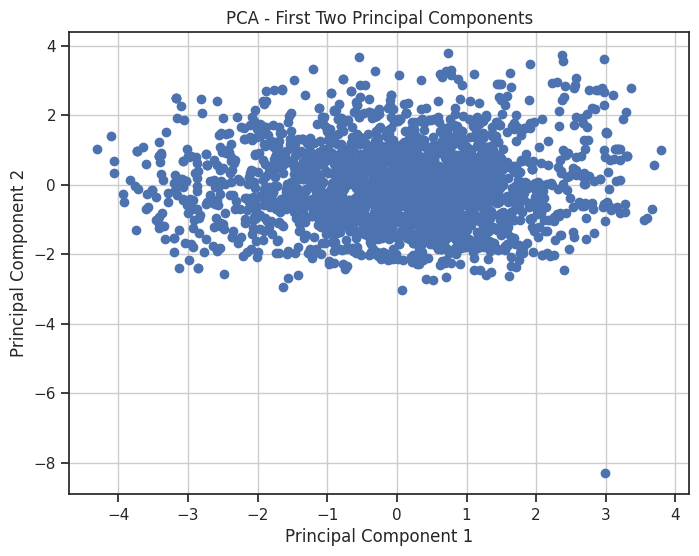

In [1852]:
# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('PCA - First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Save the PCA plot of the first two principal components to a file
plt.savefig('pca_first_two_components.png', dpi=300, bbox_inches='tight')
plt.show()

In [1853]:
# Calculate variable loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [1854]:
# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=data.columns)
print("\nVariable Loadings DataFrame:")
print(loadings_df)


Variable Loadings DataFrame:
                   PC1       PC2       PC3       PC4
Ki (nM)       0.053120 -0.162623 -0.054747  0.983923
MolWt         0.906791  0.219293 -0.075722  0.007617
MolLogP       0.679060 -0.610655 -0.239455 -0.110281
TPSA          0.111900  0.929712 -0.226042  0.095655
FractionCSP3 -0.029975  0.016553  0.955637  0.048836
BalabanJ     -0.790059 -0.153049 -0.364676 -0.008196


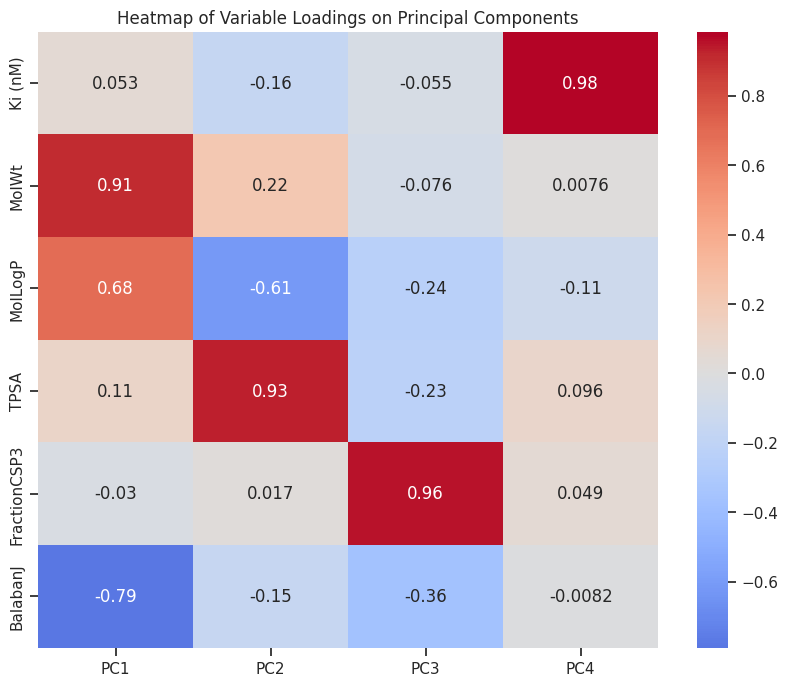

In [1855]:
# Plot the loadings for the first two principal components
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap of Variable Loadings on Principal Components")
plt.savefig('variable_loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [1856]:
# Define a scaling factor
scaling_factor = 5  # You can adjust this factor as needed

# Scale the loadings
scaled_loadings = loadings_df * scaling_factor

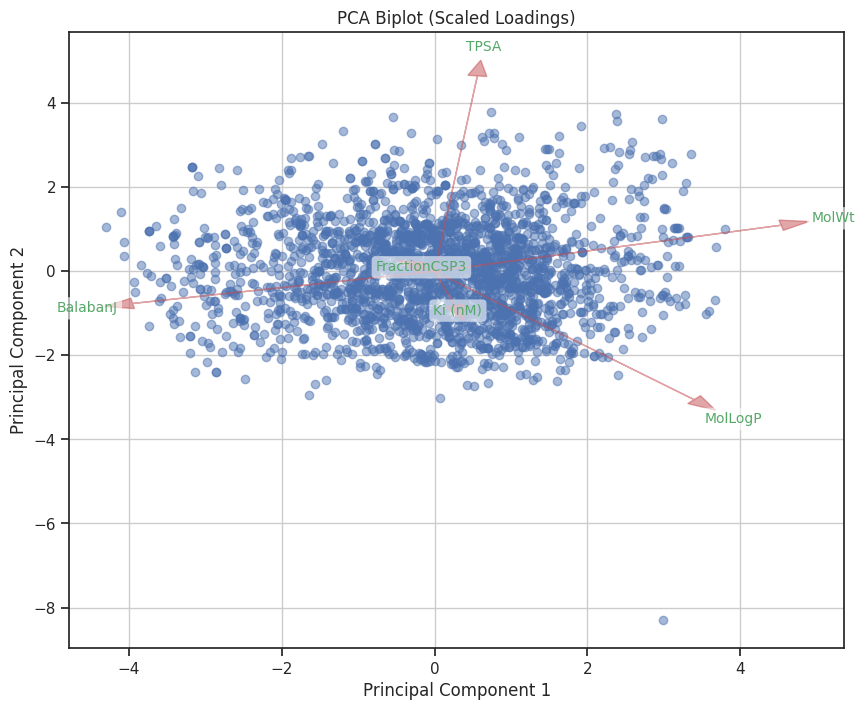

In [1857]:
# Create a biplot of the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot (Scaled Loadings)')

# Plot the scaled loadings as vectors
for i, (x, y) in enumerate(zip(scaled_loadings['PC1'], scaled_loadings['PC2'])):
    plt.arrow(0, 0, x, y, color='r', alpha=0.5, head_width=0.05 * scaling_factor)
    plt.annotate(loadings_df.index[i],
                 xy=(x, y), 
                 xytext=(1.15*x, 1.15*y),
                 textcoords='data',
                 ha='center', 
                 va='center',
                 fontsize=10,
                 color='g',
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.6))

# Save the biplot with scaled vectors to a file
plt.savefig('pca_biplot_scaled.png', dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

#### UMAP

In [1858]:
import pandas as pd
# import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import urllib.request

In [1859]:
# Standardise the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [1860]:
# Apply UMAP
umap_embedding = umap.UMAP(random_state=42).fit_transform(scaled_data)

In [1861]:
# Plot UMAP with colors based on 'Ki'
# plt.figure(figsize=(12, 10))
# palette = sns.color_palette("husl", len(data['Ki (nM)'].unique()))

# for i, ki in enumerate(data['Ki (nM)'].unique()):
#     indices = data['Ki (nM)'] == ki
#     plt.scatter(umap_embedding[indices, 0], umap_embedding[indices, 1], label=ki, color=palette[i], edgecolor='k')

# plt.title('UMAP Projection Colored by Inhibition Coefficient (Ki (nM))')
# plt.legend(title='Ki (nM)', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout(pad=3.0)

# # Save plot to file
# plt.savefig('umap_ki_plot.png')
# plt.show()

# print("UMAP plot saved to 'umap_ki_plot.png'")

#### t-SNE

In [1862]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import urllib.request

In [1863]:
# Standardise the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [1864]:
# Apply t-SNE

# note: removed max_iter=300 argument for TSNE as it was throwing an error
tsne_embedding = TSNE(random_state=42).fit_transform(scaled_data)

In [1865]:
# Plot t-SNE with colors based on 'moa'
# plt.figure(figsize=(12, 10))
# palette = sns.color_palette("husl", len(data['Ki (nM)'].unique()))
# for i, ki in enumerate(data['Ki (nM)'].unique()):
#     indices = data['Ki (nM)'] == ki
#     plt.scatter(tsne_embedding[indices, 0], tsne_embedding[indices, 1], label=ki, color=palette[i], edgecolor='k')

# plt.title('t-SNE Projection Colored by Inhibition Coefficient (Ki (nM))')
# plt.legend(title='Ki (nM)', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout(pad=3.0)

# # Save plot to file
# plt.savefig('tsne_ki_plot.png')
# plt.show()

# print("t-SNE plot saved to 'tsne_ki_plot.png'")

## Modelling

### Regression

In [1866]:
# Standard Scaling
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

#### Multiple regression using Ordinary Least Squares (OLS) regression

In [1867]:
import statsmodels.api as sm

In [1868]:
# Define the predictor and target variable
X = scaled_data.drop("Ki (nM)", axis=1) # Predictor variables (ensure X is a DataFrame), change depending on how many var's you want
y = scaled_data["Ki (nM)"] # Target variable

In [1869]:
# add a constant for the intercept
X = sm.add_constant(X)

In [1870]:
# fit the OLS model
model = sm.OLS(y, X).fit()

In [1871]:
# model summary
print("\nModel Summary: ")
print(model.summary())


Model Summary: 
                            OLS Regression Results                            
Dep. Variable:                Ki (nM)   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.495
Date:                Mon, 26 May 2025   Prob (F-statistic):              0.188
Time:                        17:34:21   Log-Likelihood:                -3488.3
No. Observations:                2461   AIC:                             6989.
Df Residuals:                    2455   BIC:                             7023.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          1.85e-17      0.

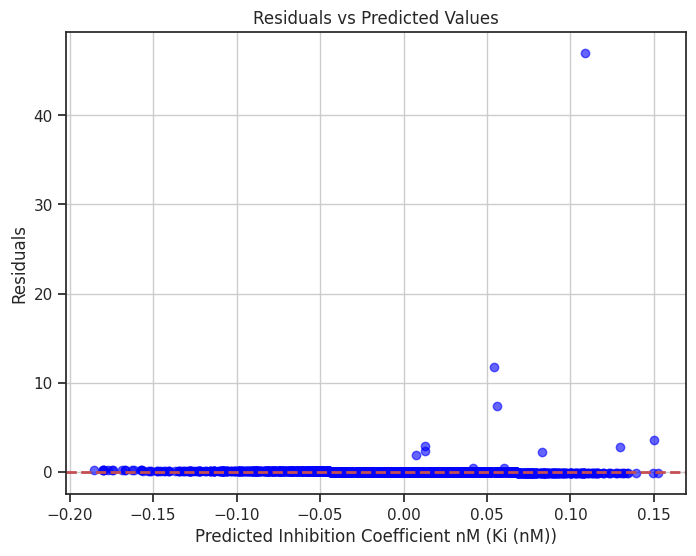

In [1872]:
# plot residuals
residuals = model.resid
predicted_values = model.fittedvalues

# Create residuals plot (Residuals vs Predicted Values)
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, alpha=0.6, color='blue')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Inhibition Coefficient nM (Ki (nM))') # change this!!!!
plt.ylabel('Residuals')
plt.grid(True)
plt.savefig('residuals_plot.png', format='png')
plt.show()

<Figure size 800x600 with 0 Axes>

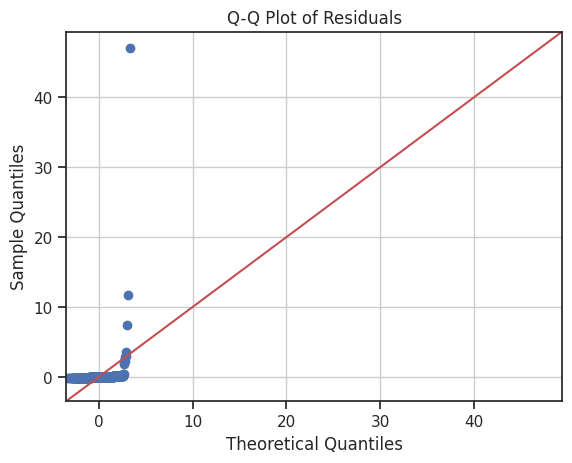

In [1873]:
# QQ plot to check for normality
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.savefig('qqplot_residuals.png', format='png')
plt.show()

Run this again with a reduced no. variables for a more concise model

In [1874]:
scaled_data.columns

Index(['Ki (nM)', 'MolWt', 'MolLogP', 'TPSA', 'FractionCSP3', 'BalabanJ'], dtype='object')

In [1875]:
# Define the predictor and target variable
X = scaled_data[["MolWt", "MolLogP", "TPSA"]] # Predictor variables (ensure X is a DataFrame), change depending on how many var's you want
y = scaled_data["Ki (nM)"] # Target variable

In [1876]:
# add a constant for the intercept
X = sm.add_constant(X)

In [1877]:
# fit the OLS model
model = sm.OLS(y, X).fit()

In [1878]:
# model summary
print("\nModel Summary: ")
print(model.summary())


Model Summary: 
                            OLS Regression Results                            
Dep. Variable:                Ki (nM)   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.263
Date:                Mon, 26 May 2025   Prob (F-statistic):             0.0792
Time:                        17:34:22   Log-Likelihood:                -3488.6
No. Observations:                2461   AIC:                             6985.
Df Residuals:                    2457   BIC:                             7008.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.85e-17      0.020   

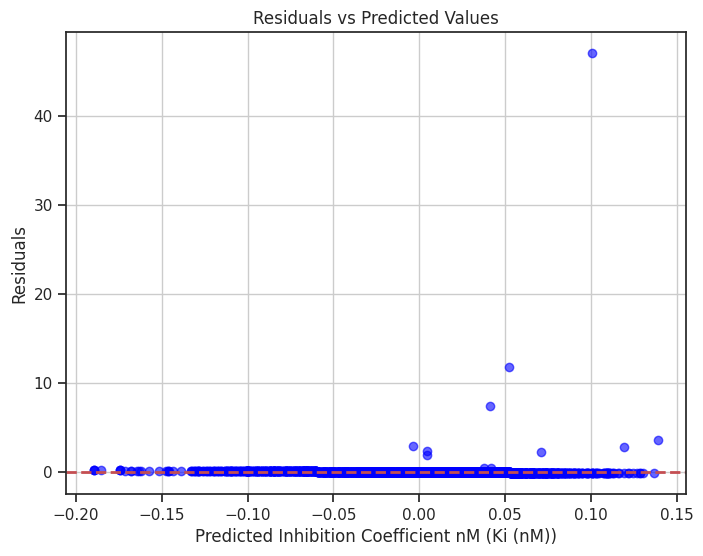

In [1879]:
# plot residuals
residuals = model.resid
predicted_values = model.fittedvalues

# Create residuals plot (Residuals vs Predicted Values)
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, alpha=0.6, color='blue')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Inhibition Coefficient nM (Ki (nM))') # change this!!!!
plt.ylabel('Residuals')
plt.grid(True)
plt.savefig('residuals_plot.png', format='png')
plt.show()

<Figure size 800x600 with 0 Axes>

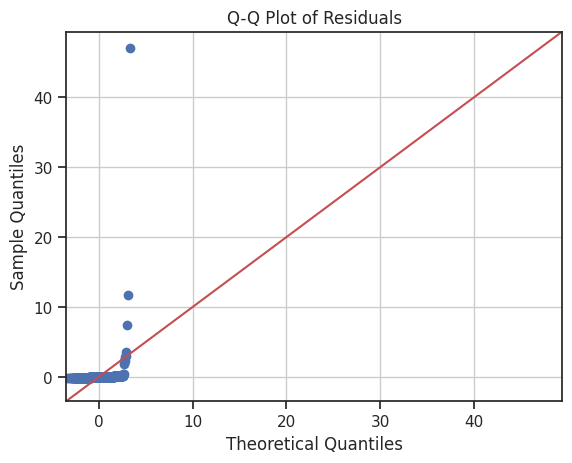

In [1880]:
# QQ plot to check for normality
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.savefig('qqplot_residuals.png', format='png')
plt.show()

#### K Nearest Neighbours

In [1881]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [1882]:
# Separate the features and target variable
X = scaled_data.drop("Ki (nM)", axis=1) 
y = scaled_data["Ki (nM)"] 

In [1883]:
# Define the range of k values to test
k_values = range(1, 31) # Test k from 1 to 30

In [1884]:
# Perform 10-Fold Cross-Validation for each k
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mean_mse_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    mse_scores = -cross_val_score(knn, X, y, scoring='neg_mean_squared_error', cv=kf)
    mean_mse_scores.append(np.mean(mse_scores))

Plot saved as: knn_mse_vs_k_plot_seaborn.png


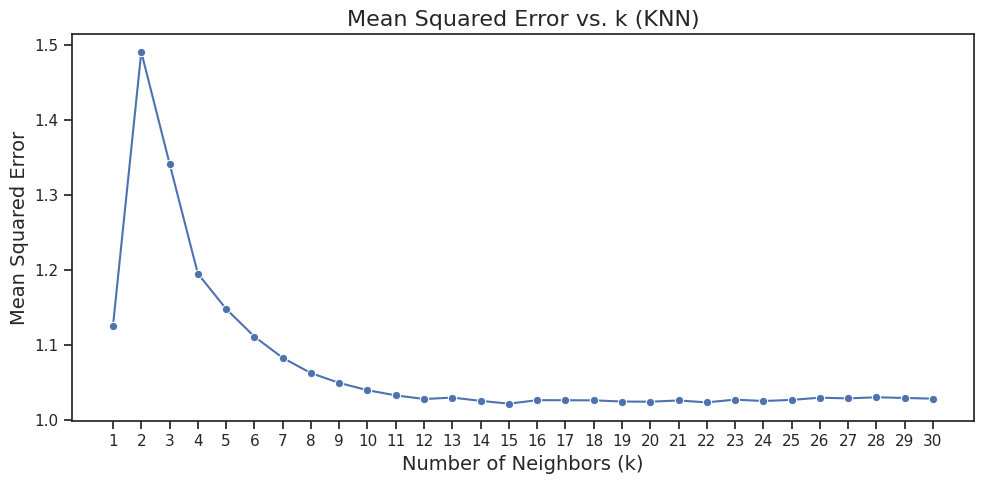

In [1885]:
# lot MSE vs. k using Seaborn
sns.set_theme(style="ticks")
plt.figure(figsize=(10, 5))
sns.lineplot(x=k_values, y=mean_mse_scores, marker="o")
plt.title('Mean Squared Error vs. k (KNN)', fontsize=16)
plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.xticks(k_values)
plt.tight_layout()

# Save the plot
output_file = 'knn_mse_vs_k_plot_seaborn.png'
plt.savefig(output_file)

print(f"Plot saved as: {output_file}")

#### Random Forest

In [1886]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [1887]:
# Separate the features and target variable
# Use all columns except the first as features, and the first column as th target variable
X = data.iloc[:, 1:] # All columns except the first
y = data.iloc[:, 0] # The first column

In [1888]:
# Perform 10-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Evaluate MSE and R-squared using cross_val_score
mse_scores = -cross_val_score(rf, X, y, scoring='neg_mean_squared_error', cv=kf)
r2_scores = cross_val_score(rf, X, y, scoring='r2', cv=kf)

In [1889]:
# alculate Mean and Standard Deviation of Metrics
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print("10-Fold Cross-Validation Results:")
print(f"Mean Squared Error: {mean_mse:.3f} ± {std_mse:.3f}")
print(f"R-squared: {mean_r2:.3f} ± {std_r2:.3f}")

10-Fold Cross-Validation Results:
Mean Squared Error: 0.001 ± 0.001
R-squared: -80903299387090595217408.000 ± 209166533274916347707392.000


##### Tuning hyper-parameters

In [1890]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.auto import tqdm
import numpy as np

In [1891]:
# Separate the features and target variable
# Use all columns except the first as features, and the first column the target variable
X = data.iloc[:, 1:] # All columns except the first
y = data.iloc[:, 0] # The first column

In [1892]:
# Define hyperparameter grid for Random Forest
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [10, 20, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

In [1893]:
# Perform Nested Cross-Validation
kf_outer = KFold(n_splits=10, shuffle=True, random_state=42) # Outer CV for evaluation
outer_results = []

print("Starting Nested Cross-Validation...")

Starting Nested Cross-Validation...


In [1894]:
for train_index, test_index in tqdm(kf_outer.split(X), total=kf_outer.get_n_splits(), desc="Outer CV Folds", leave=True):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Inner cross-validation for hyperparameter tuning
    rf = RandomForestRegressor(random_state=42)
    kf_inner = KFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf_inner, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Evaluate the best model on the outer test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    outer_results.append((mse, r2))

    tqdm.write(f"Outer Fold - Best Params: {grid_search.best_params_}, MSE: {mse:.3f}, R2: {r2:.3f}")

    # Step 5: Aggregate Results from Outer CV
    outer_mse = [result[0] for result in outer_results]
    outer_r2 = [result[1] for result in outer_results]

    mean_mse = np.mean(outer_mse)
    std_mse = np.std(outer_mse)
    mean_r2 = np.mean(outer_r2)
    std_r2 = np.std(outer_r2)

    print("\nNested Cross-Validation Results:")
    print(f"Mean Squared Error: {mean_mse:.3f} ± {std_mse:.3f}")
    print(f"R-squared: {mean_r2:.3f} ± {std_r2:.3f}")

Outer CV Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer Fold - Best Params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}, MSE: 0.000, R2: -0.304

Nested Cross-Validation Results:
Mean Squared Error: 0.000 ± 0.000
R-squared: -0.304 ± 0.000
Outer Fold - Best Params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}, MSE: 0.004, R2: -0.000

Nested Cross-Validation Results:
Mean Squared Error: 0.002 ± 0.002
R-squared: -0.152 ± 0.152
Outer Fold - Best Params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}, MSE: 0.000, R2: -123423701325949066805248.000

Nested Cross-Validation Results:
Mean Squared Error: 0.002 ± 0.002
R-squared: -41141233775316358397952.000 ± 58182490777814436937728.000
Outer Fold - Best Params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}, MSE: 0.000, R2: 0.581

Nested Cross-Validation Results:
Mean Squared Error: 0.001 ± 0.002
R-squared: -30855925331487266701312.

#### Support Vector Machine

In [1895]:
import time
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

In [1896]:
# Separate the features and target variable
# Use all columns except the first as features, and the first column the target variable↪
X = data.iloc[:, 1:] # All columns except the first
y = data.iloc[:, 0] # The first column

##### Linear kernel

In [1897]:
# define SVM model
svr = SVR(kernel='linear')

In [1898]:
# Perform simple cross-validation with timing
kf = KFold(n_splits=10, shuffle=True, random_state=42) # 10-fold CV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Start timer
start_time = time.time()

mse_scores = cross_val_score(svr, X, y, cv=kf, scoring=mse_scorer, n_jobs=-1)
r2_scores = cross_val_score(svr, X, y, cv=kf, scoring=r2_scorer, n_jobs=-1)

# End timer
end_time = time.time()

In [1899]:
# Report results and elapsed time
mean_mse = -np.mean(mse_scores) # Convert back to positive MSE
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

elapsed_time = end_time - start_time

print("\nCross-Validation Results:")
print(f"Mean Squared Error: {mean_mse:.3f} ± {std_mse:.3f}")
print(f"R-squared: {mean_r2:.3f} ± {std_r2:.3f}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Cross-Validation Results:
Mean Squared Error: 0.010 ± 0.001
R-squared: -10804478673991153041276928.000 ± 15125295234604275511328768.000
Elapsed Time: 0.04 seconds


##### Default RBF kernel

In [1900]:
# define SVM model
svr = SVR()

In [1901]:
# Perform simple cross-validation with timing
kf = KFold(n_splits=10, shuffle=True, random_state=42) # 10-fold CV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Start timer
start_time = time.time()

mse_scores = cross_val_score(svr, X, y, cv=kf, scoring=mse_scorer, n_jobs=-1)
r2_scores = cross_val_score(svr, X, y, cv=kf, scoring=r2_scorer, n_jobs=-1)

# End timer
end_time = time.time()

In [1902]:
# Step 5: Report results and elapsed time
mean_mse = -np.mean(mse_scores) # Convert back to positive MSE
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

elapsed_time = end_time - start_time

print("\nCross-Validation Results:")
print(f"Mean Squared Error: {mean_mse:.3f} ± {std_mse:.3f}")
print(f"R-squared: {mean_r2:.3f} ± {std_r2:.3f}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Cross-Validation Results:
Mean Squared Error: 0.009 ± 0.001
R-squared: -9838145052964745474211840.000 ± 13761976705973227064655872.000
Elapsed Time: 0.07 seconds


##### Nested cross-validation

In [1903]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.auto import tqdm

In [1904]:
# Separate the features and target variable
# Use all columns except the first as features, and the first column the target variable↪
X = data.iloc[:, 1:] # All columns except the first
y = data.iloc[:, 0] # The first column

In [1905]:
# Define hyperparameter grid for RBF kernel
param_grid_rbf = {'kernel': ['rbf'], 'C': [1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1]}

In [1906]:
# Nested CV Function for RBF kernel
def nested_cv_rbf(param_grid):
    print("\nStarting Nested Cross-Validation for RBF kernel...")
    kf_outer = KFold(n_splits=10, shuffle=True, random_state=42)
    outer_results = []

    for train_index, test_index in tqdm(kf_outer.split(X), total=kf_outer.get_n_splits(), desc="Outer CV Folds", leave=True):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Inner cross-validation using GridSearchCV
    svm = SVR()
    kf_inner = KFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf_inner)
    grid_search.fit(X_train, y_train)

    # Evaluate the best model on the outer test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    outer_results.append((mse, r2))

    tqdm.write(f"Outer Fold - Best Params: {grid_search.best_params_}, MSE: {mse:.3f}, R2: {r2:.3f}")

    # Aggregate results
    outer_mse = [result[0] for result in outer_results]
    outer_r2 = [result[1] for result in outer_results]

    mean_mse = np.mean(outer_mse)
    std_mse = np.std(outer_mse)
    mean_r2 = np.mean(outer_r2)
    std_r2 = np.std(outer_r2)
    
    print("\nNested Cross-Validation Results for RBF kernel:")
    print(f"Mean Squared Error: {mean_mse:.3f} ± {std_mse:.3f}")
    print(f"R-squared: {mean_r2:.3f} ± {std_r2:.3f}")
    return mean_mse, std_mse, mean_r2, std_r2

In [1907]:
# Start timing the script
start_time = time.time()

# Perform Nested Cross-Validation for RBF kernel
rbf_results = nested_cv_rbf(param_grid_rbf)

# Calculate and print runtime
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal Execution Time: {elapsed_time:.2f} seconds")


Starting Nested Cross-Validation for RBF kernel...


Outer CV Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer Fold - Best Params: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}, MSE: 0.002, R2: -218.789

Nested Cross-Validation Results for RBF kernel:
Mean Squared Error: 0.002 ± 0.000
R-squared: -218.789 ± 0.000

Total Execution Time: 2.64 seconds


#### XGBoost

In [1908]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1909]:
import time
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

In [1910]:
# Separate the features and target variable
# Use all columns except the first as features, and the first column the target variable↪
X = data.iloc[:, 1:] # All columns except the first
y = data.iloc[:, 0] # The first column

In [1911]:
# Define XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [1912]:
# Perform simple cross-validation with timing
kf = KFold(n_splits=10, shuffle=True, random_state=42) # 10-fold CV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

In [1913]:
# Start timing the script
start_time = time.time()

mse_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring=mse_scorer, n_jobs=-1)
r2_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring=r2_scorer, n_jobs=-1)

# End timer
end_time = time.time()

In [1914]:
# Report results and elapsed time
mean_mse = -np.mean(mse_scores) # Convert back to positive MSE
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

elapsed_time = end_time - start_time

print("\nCross-Validation Results:")
print(f"Mean Squared Error: {mean_mse:.3f} ± {std_mse:.3f}")
print(f"R-squared: {mean_r2:.3f} ± {std_r2:.3f}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Cross-Validation Results:
Mean Squared Error: 0.001 ± 0.002
R-squared: -1541026038624611477749760.000 ± 2971507977784912664068096.000
Elapsed Time: 0.24 seconds


##### XGBoost with grid search

In [1915]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [1916]:
# Separate the features and target variable
# Use all columns except the first as features, and the first column the target variable↪
X = data.iloc[:, 1:] # All columns except the first
y = data.iloc[:, 0] # The first column

In [1917]:
# define XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [1918]:
# Set up hyperparameter grid
param_grid = {'n_estimators': [50, 100, 200],'max_depth': [3, 5, 7],'learning_rate': [0.01, 0.1, 0.2],'subsample': [0.6, 0.8, 1.0],'colsample_bytree': [0.6, 0.8, 1.0],'gamma': [0, 0.1, 0.2],}

In [1919]:
# Set up cross-validation and GridSearchCV
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', # Optimize for negative MSE 
                           cv=kf, n_jobs=-1, verbose=1)

In [1920]:
# Start timer and perform grid search
start_time = time.time()
grid_search.fit(X, y)
end_time = time.time()

Fitting 10 folds for each of 729 candidates, totalling 7290 fits


In [1921]:
# Extract the best model and results
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate with cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

mse_scores = -cross_val_score(best_model, X, y, cv=kf,scoring=mse_scorer, n_jobs=-1)
r2_scores = cross_val_score(best_model, X, y, cv=kf,scoring=r2_scorer, n_jobs=-1)

mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

elapsed_time = end_time - start_time

In [1922]:
#  Report results
print("\nHyperparameter Tuning Results:")
print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error: {mean_mse:.3f} ± {std_mse:.3f}")
print(f"R-squared: {mean_r2:.3f} ± {std_r2:.3f}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Hyperparameter Tuning Results:
Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Mean Squared Error: 0.000 ± 0.001
R-squared: -829131380332223660032.000 ± 1238819585120425476096.000
Elapsed Time: 51.86 seconds
